# Perturbing cell type composition

## imports & setup

In [1]:
import importlib
import logging

import dask.dataframe as dd
import helpers
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from upath import UPath

In [2]:
helpers.logging.configure_logging()
logging.getLogger("helpers").setLevel("DEBUG")

In [3]:
logger = logging.getLogger(__name__)
logger.setLevel("DEBUG")
logger.debug("test")

2022-12-15 05:33:54,913 27614/MainThread __main__ DEBUG
test


In [4]:
!gsutil ls gs://liulab/differential_composition

gs://liulab/differential_composition/20221208_04h48m35s/
gs://liulab/differential_composition/20221208_13h36m30s/
gs://liulab/differential_composition/20221208_13h41m58s/
gs://liulab/differential_composition/20221208_13h53m39s/
gs://liulab/differential_composition/20221208_14h18m38s/
gs://liulab/differential_composition/20221215_04h17m18s/
gs://liulab/differential_composition/20221215_04h37m55s/
gs://liulab/differential_composition/20221215_04h42m35s/
gs://liulab/differential_composition/20221215_05h06m59s/
gs://liulab/differential_composition/20221215_05h09m48s/


In [58]:
path_root = UPath("gs://liulab/differential_composition") / "20221215_04h42m35s"
# 20221208_14h18m38s last week
# 20221215_05h09m48s like last week but with more 0 perturbation experiments
# 20221215_05h06m59s recreation of last week, showed a significantly different perturbation=0
# 20221215_04h42m35s with N = 1000

## Examining generated data

### Distributions of composition

In [59]:
# df_fractions = dd.read_parquet(path_root / "*" / "fractions.parquet").drop("malignant_fraction_log2_fc", axis=1)
df_fractions = pd.concat([pd.read_parquet(p) for p in path_root.glob("*/fractions.parquet")])

In [61]:
df_fractions.sample(5)

cell_type                                                 B      CAF  \
sample_id                                                              
rng_seed=10,malignant_fraction_log2_fc=0.000/sa... 0.014060 0.104147   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa... 0.018471 0.556483   
rng_seed=8,malignant_fraction_log2_fc=0.000/sam... 0.000000 0.219736   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa... 0.045530 0.083687   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa... 0.000000 0.530125   

cell_type                                           Endothelial  Macrophage  \
sample_id                                                                     
rng_seed=10,malignant_fraction_log2_fc=0.000/sa...     0.000189    0.091447   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa...     0.010064    0.067340   
rng_seed=8,malignant_fraction_log2_fc=0.000/sam...     0.029095    0.271804   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa...     0.037091    0.063816   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa...     0.010851    0.000000   

cell_type                                           Malignant       NK  \
sample_id                                                                
rng_seed=10,malignant_fraction_log2_fc=0.000/sa...   0.738506 0.000000   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa...   0.343069 0.000000   
rng_seed=8,malignant_fraction_log2_fc=0.000/sam...   0.345453 0.000000   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa...   0.769875 0.000000   
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa...   0.458527 0.000498   

cell_type                                                 T    T CD4    T CD8  
sample_id                                                                      
rng_seed=10,malignant_fraction_log2_fc=0.000/sa... 0.000000 0.030505 0.021146  
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa... 0.000000 0.000000 0.004572  
rng_seed=8,malignant_fraction_log2_fc=0.000/sam... 0.000000 0.117071 0.016842  
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa... 0.000000 0.000000 0.000000  
rng_seed=5,malignant_fraction_log2_fc=-2.000/sa... 0.000000 0.000000 0.000000

In [62]:
assert np.allclose(df_fractions.sum(axis=1), 1.0)

In [63]:
df_fractions["source"] = df_fractions.index.str.split("/").map(lambda x: x[0])

In [64]:
df_fractions

cell_type                                                 B      CAF  \
sample_id                                                              
control/sample_000                                 0.000000 0.182027   
control/sample_001                                 0.001198 0.069004   
control/sample_002                                 0.004649 0.012770   
control/sample_003                                 0.000000 0.006421   
control/sample_004                                 0.015146 0.077427   
...                                                     ...      ...   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.000620 0.018141   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.021607 0.005787   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.003418 0.032235   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.000000 0.018074   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.016066 0.016745   

cell_type                                           Endothelial  Macrophage  \
sample_id                                                                     
control/sample_000                                     0.012565    0.093271   
control/sample_001                                     0.002454    0.124925   
control/sample_002                                     0.059430    0.048314   
control/sample_003                                     0.001139    0.005270   
control/sample_004                                     0.001205    0.000000   
...                                                         ...         ...   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...     0.003912    0.001926   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...     0.002341    0.047694   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...     0.008852    0.024933   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...     0.014756    0.025941   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...     0.000223    0.011683   

cell_type                                           Malignant       NK  \
sample_id                                                                
control/sample_000                                   0.667673 0.001163   
control/sample_001                                   0.773232 0.000000   
control/sample_002                                   0.859441 0.000000   
control/sample_003                                   0.981224 0.000000   
control/sample_004                                   0.905786 0.000436   
...                                                       ...      ...   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...   0.975401 0.000000   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...   0.876089 0.000000   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...   0.921341 0.000000   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...   0.930802 0.000311   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam...   0.951828 0.000000   

cell_type                                                 T    T CD4    T CD8  \
sample_id                                                                       
control/sample_000                                 0.000000 0.043301 0.000000   
control/sample_001                                 0.000000 0.029187 0.000000   
control/sample_002                                 0.000000 0.015396 0.000000   
control/sample_003                                 0.005947 0.000000 0.000000   
control/sample_004                                 0.000000 0.000000 0.000000   
...                                                     ...      ...      ...   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.000000 0.000000 0.000000   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.000000 0.027516 0.018965   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.000000 0.009221 0.000000   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.000000 0.010116 0.000000   
rng_seed=9,malignant_fraction_log2_fc=1.000/sam... 0.003453 0.000000 0.000000   

cell_type         

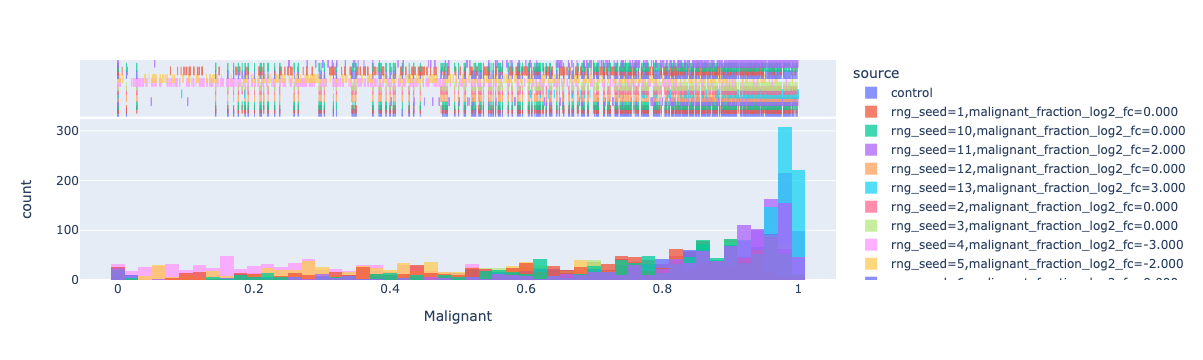

In [65]:
fig = px.histogram(
    df_fractions,
    x="Malignant",
    color="source",
    marginal="rug",
    hover_data=df_fractions.columns,
)
fig.update_layout(barmode="overlay")
fig.update_traces(opacity=0.75)
# fig.update_layout(
#     title_text="Sampled Results",  # title of plot
#     xaxis_title_text="Value",  # xaxis label
#     yaxis_title_text="Count",  # yaxis label
#     bargap=0.2,  # gap between bars of adjacent location coordinates
#     bargroupgap=0.1,  # gap between bars of the same location coordinates
# )
fig.show()

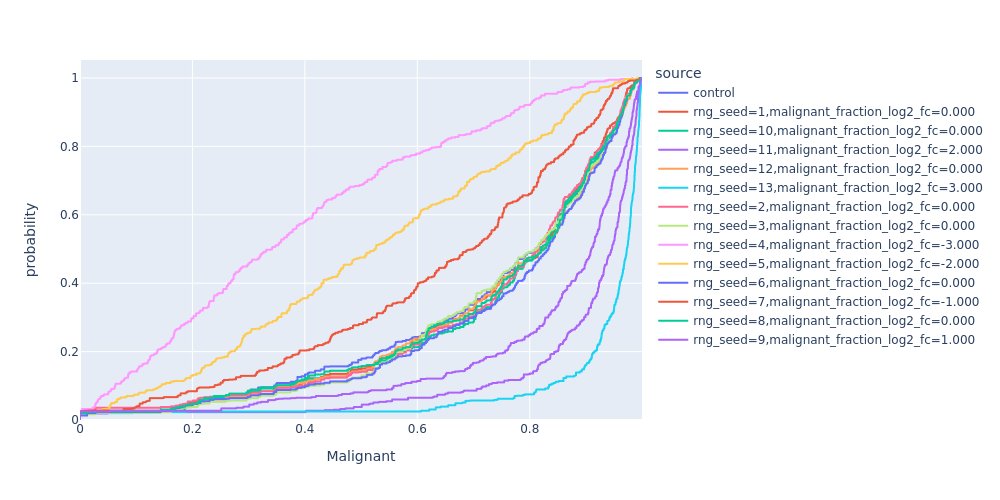

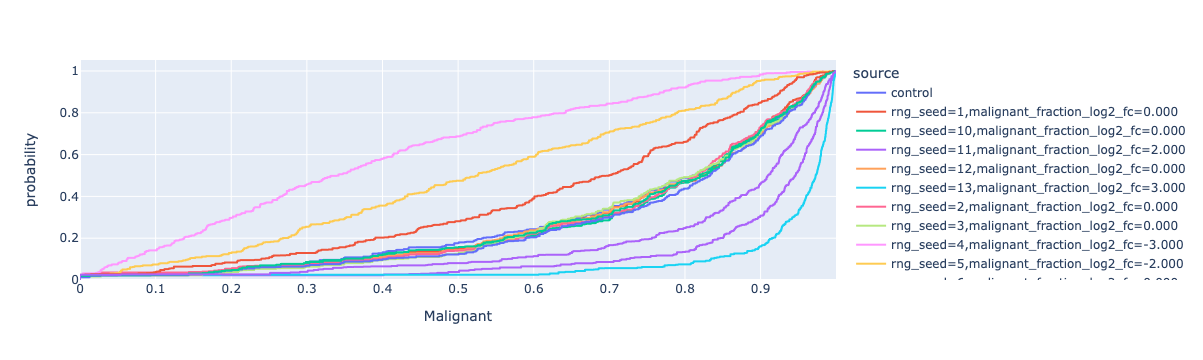

In [66]:
fig = px.ecdf(df_fractions, x="Malignant", color="source")
fig.show(renderer="png", width=1000)
fig.show()

In [69]:
from scipy.stats import mannwhitneyu

pd.options.display.float_format = "{:.6f}".format

df_fractions.groupby("source").apply(
    lambda group: mannwhitneyu(x=group["Malignant"], y=df_fractions.query("source=='control'")["Malignant"])[1]
).iloc[[0, 1, 6, 7, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5]]

source
control                                        1.000000
rng_seed=1,malignant_fraction_log2_fc=0.000    0.931868
rng_seed=2,malignant_fraction_log2_fc=0.000    0.756976
rng_seed=3,malignant_fraction_log2_fc=0.000    0.602379
rng_seed=4,malignant_fraction_log2_fc=-3.000   0.000000
rng_seed=5,malignant_fraction_log2_fc=-2.000   0.000000
rng_seed=6,malignant_fraction_log2_fc=0.000    0.035934
rng_seed=7,malignant_fraction_log2_fc=-1.000   0.000000
rng_seed=8,malignant_fraction_log2_fc=0.000    0.562416
rng_seed=9,malignant_fraction_log2_fc=1.000    0.000000
rng_seed=10,malignant_fraction_log2_fc=0.000   0.352158
rng_seed=11,malignant_fraction_log2_fc=2.000   0.000000
rng_seed=12,malignant_fraction_log2_fc=0.000   0.295832
rng_seed=13,malignant_fraction_log2_fc=3.000   0.000000
dtype: float64

In [70]:
from scipy.stats import ks_2samp

df_fractions.groupby("source").apply(
    lambda group: ks_2samp(group["Malignant"], df_fractions.query("source=='control'")["Malignant"])[1]
).iloc[[0, 1, 6, 7, 8, 9, 10, 11, 12, 13, 2, 3, 4, 5]]

source
control                                        1.000000
rng_seed=1,malignant_fraction_log2_fc=0.000    0.465960
rng_seed=2,malignant_fraction_log2_fc=0.000    0.263472
rng_seed=3,malignant_fraction_log2_fc=0.000    0.097103
rng_seed=4,malignant_fraction_log2_fc=-3.000   0.000000
rng_seed=5,malignant_fraction_log2_fc=-2.000   0.000000
rng_seed=6,malignant_fraction_log2_fc=0.000    0.022439
rng_seed=7,malignant_fraction_log2_fc=-1.000   0.000000
rng_seed=8,malignant_fraction_log2_fc=0.000    0.722825
rng_seed=9,malignant_fraction_log2_fc=1.000    0.000000
rng_seed=10,malignant_fraction_log2_fc=0.000   0.120515
rng_seed=11,malignant_fraction_log2_fc=2.000   0.000000
rng_seed=12,malignant_fraction_log2_fc=0.000   0.500567
rng_seed=13,malignant_fraction_log2_fc=3.000   0.000000
dtype: float64

## differential expression analysis

### individual plots

In [ ]:
# experiment_paths = [path_root / "log2_fc=0.000"]  # control
# title = "Negative control"

# experiment_paths = [path_root / "log2_fc=2.000"]
# title = "$\log_{2} [FC] = 2.0$"

experiment_paths = [
    path_root / "malignant_fraction_log2_fc=0.000",
    # path_root / "malignant_fraction_log2_fc=-0.250",
    # path_root / "malignant_fraction_log2_fc=-0.500",
    path_root / "malignant_fraction_log2_fc=-1.000",
    # path_root / "malignant_fraction_log2_fc=1.000",
    # path_root / "malignant_fraction_log2_fc=-2.000",
]
title = ""

experiment_paths

In [ ]:
importlib.reload(helpers.running_cibersortx.reading_output_files)

from helpers.running_cibersortx.reading_output_files import read_hires_cell_type_gep

key_names = ["experiment_name", "data_origin"]

experiments_data = dict()
for path in experiment_paths:
    experiments_data[(path.name, "bulk RNA-seq")] = pd.read_parquet(path / "deg_analysis/gene_stats_bulk.parquet")
    experiments_data[(path.name, "malignant cells (cibersortx)")] = pd.read_parquet(
        path / "deg_analysis/gene_stats_malignant_cibersortx.parquet"
    )

all_dge_results = pd.concat(experiments_data, names=key_names).reset_index(key_names).reset_index(drop=True)

In [ ]:
importlib.reload(helpers.deg_analysis)

from helpers.deg_analysis import add_fdr_lines, make_volcano_facets

fig = make_volcano_facets(all_dge_results, horizontal=True)
fig = add_fdr_lines(fig, all_dge_results, horizontal=True)
# fig.update_layout(title=title, height=1200)
fig.update_layout(height=700, width=1000)

fig.show(renderer="png", scale=1)

## Classifying genes as differential: evaluation & ROC curves

In [ ]:
gene_stats_malignant_cibersortx = all_dge_results.query("data_origin == 'malignant cells (cibersortx)'")
y = gene_stats_malignant_cibersortx["perturbed"]
y_score = gene_stats_malignant_cibersortx["-log10_pval"]

In [ ]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(y, y_score)

print(fpr.shape, tpr.shape, thresholds.shape)

fig = px.line(
    x=fpr,
    y=tpr,
    # title=f"ROC Curve (AUC={auc(fpr, tpr):.4f})",
    labels=dict(x="False Positive Rate", y="True Positive Rate"),
    width=400,
    height=400,
    hover_data={"Threshold of -log10(pval)": thresholds},
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1, dtick=0.2)
fig.update_xaxes(constrain="domain", dtick=0.2)
fig.show(renderer="png", scale=2)

In [ ]:
from sklearn.metrics import auc, precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y, y_score)

print(precision.shape, recall.shape, thresholds.shape)

fig = px.line(
    x=recall[1:],
    y=precision[1:],
    # title=f"Precision & Recall",
    labels=dict(x="Recall", y="Precision"),
    width=400,
    height=400,
    hover_data={"Threshold of -log10(pval)": thresholds},
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=1, y1=0)
fig.update_yaxes(scaleanchor="x", scaleratio=1, dtick=0.2)
fig.update_xaxes(constrain="domain", dtick=0.2)
# fig.update_xaxes(minor=dict(showgrid=True))
# fig.update_yaxes(minor=dict(showgrid=True))
fig.show(renderer="png", scale=2)

### multiple fold-changes

In [ ]:
experiment_paths = list(path_root.glob("malignant_fraction_log2_fc=*"))
experiment_paths = list(sorted(experiment_paths, key=lambda p: float(str(p).split("=")[1])))
experiment_paths

In [ ]:
importlib.reload(helpers.running_cibersortx.reading_output_files)

from helpers.running_cibersortx.reading_output_files import read_hires_cell_type_gep
from sklearn.metrics import auc, precision_recall_curve, roc_curve

key_names = ["experiment_name", "data_origin"]

df_roc = pd.DataFrame()
df_pr = pd.DataFrame()

experiments_data = dict()
for i, path in enumerate(experiment_paths):
    df = pd.read_parquet(path / "deg_analysis/gene_stats_malignant_cibersortx.parquet")
    y = df["perturbed"]
    y_score = df["-log10_pval"]
    fpr, tpr, thresholds = roc_curve(y, y_score)
    # print(fpr.shape, tpr.shape, thresholds.shape)
    description = f"{path.name} (AUC={auc(fpr, tpr):.4f})"
    df_roc_this_experiment = pd.DataFrame(
        dict(
            description=description,
            fpr=fpr,
            tpr=tpr,
            thresholds=thresholds,
            color=np.linspace(-2, 2, len(experiment_paths))[i],
        )
    )
    df_roc = pd.concat([df_roc, df_roc_this_experiment])
    precision, recall, thresholds = precision_recall_curve(y, y_score)
    print(precision.shape, recall.shape, thresholds.shape)
    df_pr_this_experiment = pd.DataFrame(
        dict(
            description=path.name,
            precision=precision[1:],
            recall=recall[1:],
            thresholds=thresholds,
            color=np.linspace(-2, 2, len(experiment_paths))[i],
        )
    )
    df_pr = pd.concat([df_pr, df_pr_this_experiment])


# all_dge_results = pd.concat(experiments_data, names=key_names).reset_index(key_names).reset_index(drop=True)

In [ ]:
df_roc

In [ ]:
df_pr

In [ ]:
n_colors = df_roc["description"].nunique()
colors = px.colors.sample_colorscale("Picnic", [n / (n_colors - 1) for n in range(n_colors)])

In [ ]:
fig = px.line(
    df_roc,
    x="fpr",
    y="tpr",
    color="description",
    # title=f"ROC Curve (AUC={auc(fpr, tpr):.4f})",
    labels=dict(fpr="False Positive Rate", tpr="True Positive Rate"),
    width=800,
    height=600,
    color_discrete_sequence=colors,
    # hover_data=["thresholds"],
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain="domain")
fig.show(renderer="png", scale=2)

In [ ]:
fig = px.line(
    df_pr,
    x="recall",
    y="precision",
    color="description",
    labels=dict(recall="Recall", precision="Precision"),
    width=800,
    height=600,
    color_discrete_sequence=colors,
    # hover_data={"Threshold of -log10(pval)": thresholds},
)
fig.add_shape(type="line", line=dict(dash="dash"), x0=0, x1=1, y0=0, y1=1)
fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain="domain")
fig.show(renderer="png", scale=2)

In [ ]:
path_image = path_root / "figures" / "volcanos_facets_vertical.png"

fig.write_image(path_image, scale=2)

print(path_image)
print(f"gsutil cp {path_image} ~/Downloads/{path_root.name}")